# **FS25 NLP Project 1: Word Embeddings/Recurrent Neural Networks**

Fabian Dubach

# **Introduction**

The task for this project was to answer common sense questions with the usage of two different architectures: Word embeddings (word2vec, GloVe or fastText) with a classifier and a 2-layer RNN architecture with a classifier (LSTM or GRU). We had to also track the trainings with Wandb (workspace URL: https://wandb.ai/fabian-dubach-hochschule-luzern/experiment-tracking/runs/gtg68kwg/workspace?nw=nwuserfabiandubach).

# **Setup**

Import all libraries needed to run the code

In [108]:
import torch
import torch.nn as nn
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import gensim.downloader as api
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from lightning.pytorch.loggers import WandbLogger

Setup random seed to ensure reproducibility

_Info about the seed value: The field of natural language processing began in the 1940s, after World War II. At this time, people recognized the importance of translation from one language to another and hoped to create a machine that could do this sort of translation automatically._

In [2]:
SEED = 1940

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Download tokenizer files

In [99]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load pre-trained GloVe word embeddings (300 dimensions)

I chose GloVe because I've seen that GloVe performs well on semantic similarity and analogical reasoning. In comparison to FastText, Glove can't handle unknown words and typos, but this disadvantage is often outweighed by GloVe's stronger performance on semantic relationships. I used 300 dimensions because it represents word meanings more completely than smaller options (50- or 100 dimensions) while still being practical to use.

In [5]:
glove_model = api.load('glove-wiki-gigaword-300')

For the project, we had to use the CommonsenseQA dataset, which is a multiple-choice question answering dataset that contains 12'247 different questions and was developed to benchmark machine understanding of everyday knowledge. For each questions there are 5 given answer choices, where only one of them is correct. To be able to answer these questions, "commonsense" is needed. The dataset is available on HuggingFace: https://huggingface.co/datasets/tau/commonsense_qa.

I split the dataset into training, validation and test sets to allow for model development and evaluation. I used the last 1'000 examples from the training set for validation and the original validation set for testing, since the real test set has no answer keys.

In [6]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


# **Data Exploration**

In this section I tried to get some insight to understand its structure and patterns.

### 1. Explore dataset structure

In [70]:
print("\033[4m" + "Dataset Features" + "\033[0m")
for feature in train.features:
    print(feature)
print("\n" + "\033[4m" + "Example" + "\033[0m")
for feature in train.features:
    print(feature + ":", train[0][str(feature)])

Dataset Features
id
question
question_concept
choices
answerKey

Example
id: 075e483d21c29a511267ef62bedc0461
question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
question_concept: punishing
choices: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
answerKey: A


### 2. Get a general info about each dataset

In [64]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset)

train_df = dataset_to_df(train)
valid_df = dataset_to_df(valid)
test_df = dataset_to_df(test)

In [71]:
print("\033[4m" + "Train Info" + "\033[0m")
print(train_df.info())

Train Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8741 non-null   object
 1   question          8741 non-null   object
 2   question_concept  8741 non-null   object
 3   choices           8741 non-null   object
 4   answerKey         8741 non-null   object
dtypes: object(5)
memory usage: 341.6+ KB
None


In [72]:
print("\033[4m" + "Validation Info" + "\033[0m")
print(valid_df.info())

Validation Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1000 non-null   object
 1   question          1000 non-null   object
 2   question_concept  1000 non-null   object
 3   choices           1000 non-null   object
 4   answerKey         1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB
None


In [73]:
print("\033[4m" + "Test Info" + "\033[0m")
print(test_df.info())

Test Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1221 non-null   object
 1   question          1221 non-null   object
 2   question_concept  1221 non-null   object
 3   choices           1221 non-null   object
 4   answerKey         1221 non-null   object
dtypes: object(5)
memory usage: 47.8+ KB
None


### 3. Analyze question lengths

In [81]:
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

combined_df['question_length'] = combined_df['question'].apply(len)
combined_df['question_word_count'] = combined_df['question'].apply(lambda x: len(x.split()))

print("\033[4m" + "Question length (characters)" + "\033[0m")
print(f"Min: {combined_df['question_length'].min()}")
print(f"Max: {combined_df['question_length'].max()}")
print(f"Mean: {combined_df['question_length'].mean():.2f}")
print(f"Median: {combined_df['question_length'].median()}")

print("\n\033[4m" + "Question Word Count" + "\033[0m")
print(f"Min: {combined_df['question_word_count'].min()}")
print(f"Max: {combined_df['question_word_count'].max()}")
print(f"Mean: {combined_df['question_word_count'].mean():.2f}")
print(f"Median: {combined_df['question_word_count'].median()}")

Question length (characters)
Min: 15
Max: 376
Mean: 69.31
Median: 64.0

Question Word Count
Min: 3
Max: 63
Mean: 13.23
Median: 12.0


### 4. Analyze option lengths

In [83]:
def get_option_lengths(choices):
    return [len(text) for text in choices['text']]

def get_option_word_counts(choices):
    return [len(text.split()) for text in choices['text']]

combined_df['option_lengths'] = combined_df['choices'].apply(get_option_lengths)
combined_df['option_word_counts'] = combined_df['choices'].apply(get_option_word_counts)

# Flatten the lists for analysis
all_option_lengths = [length for lengths in combined_df['option_lengths'] for length in lengths]
all_option_word_counts = [count for counts in combined_df['option_word_counts'] for count in counts]

print("\033[4m" + "Option length (characters)" + "\033[0m")
print(f"Min: {min(all_option_lengths)}")
print(f"Max: {max(all_option_lengths)}")
print(f"Mean: {np.mean(all_option_lengths):.2f}")
print(f"Median: {np.median(all_option_lengths)}")

print("\033[4m" + "\nOption word count" + "\033[0m")
print(f"Min: {min(all_option_word_counts)}")
print(f"Max: {max(all_option_word_counts)}")
print(f"Mean: {np.mean(all_option_word_counts):.2f}")
print(f"Median: {np.median(all_option_word_counts)}")

Option length (characters)
Min: 3
Max: 149
Mean: 9.34
Median: 9.0

Option word count
Min: 1
Max: 26
Mean: 1.52
Median: 1.0


### 5. Analyze answer distribution

In [94]:
def extract_answer_letter(example):
    return example['answerKey']

combined_df['answer_letter'] = combined_df.apply(extract_answer_letter, axis=1)

print("\033[4m" + "Answer Distribution" + "\033[0m")
print(combined_df['answer_letter'].value_counts(), "\n")
print(combined_df['answer_letter'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Answer Distribution
answer_letter
D    2236
B    2228
C    2187
E    2163
A    2148
Name: count, dtype: int64 

answer_letter
D     20.4%
B    20.32%
C    19.95%
E    19.73%
A    19.59%
Name: proportion, dtype: object


### 6. Extract common question words/phrases

In [104]:
def get_common_words(text_series, top_n=20):
    stop_words = set(stopwords.words('english'))
    all_words = []
    
    for text in text_series:
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
        all_words.extend(filtered_words)
    
    return Counter(all_words).most_common(top_n)

print("\033[4m" + "Common Words in Questions" + "\033[0m")
common_words = get_common_words(train_df['question'], 10)
for word, count in common_words:
    print(f"{word}: {count}")

Common Words in Questions
would: 1101
people: 694
might: 669
likely: 637
someone: 556
find: 509
could: 502
person: 498
get: 372
one: 367


### 7. Visualize question length distribution

Text(0, 0.5, 'Frequency')

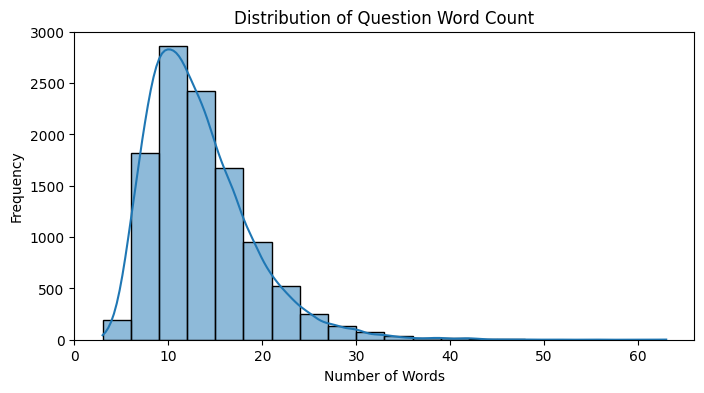

In [118]:
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['question_word_count'], bins=20, kde=True)
plt.title('Distribution of Question Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

### 8. Visualize answer distribution

Text(0, 0.5, 'Count')

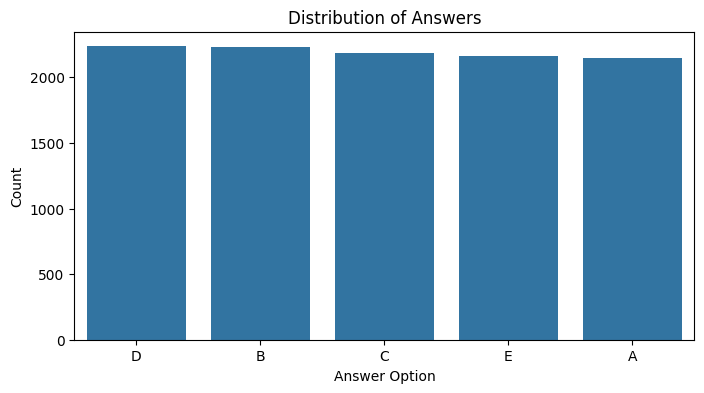

In [116]:
plt.figure(figsize=(8, 4))
sns.countplot(x='answer_letter', data=combined_df, order=combined_df['answer_letter'].value_counts().index)
plt.title('Distribution of Answers')
plt.xlabel('Answer Option')
plt.ylabel('Count')

# **Preprocessing**

For the preprocessing I looked at the following points:

1. Tokenization
2. Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
3. Removal of unknown/other words 
4. Format cleaning (e.g. html-extracted text) 
5. Truncation 
6. Feature selection 
7. Input format: how is data passed to the model? 
8. Label format: what should the model predict?
9. Batching, padding 
10. Vocabulary, embedding 

Here are my decisions and justifications for using or not using the above listed preprocessing methods:

1. Tokenization is absolutely mandatory.
2. I chose not to use lowercasing to keep the semantic meaning of the words. Stemming and lemmatizing are not needed, because GloVe already captures semantic similarities. Stopword/Punctuation removal is generally not a needed for a RNN due to the fact that the model can then learn to ignore irrelevant words by itself.
3. 

In [ ]:
def preprocessing(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens